In [39]:
%load_ext autoreload
%autoreload
import inlp_dataset_handler
import inlp
import inlp_linear_model
import numpy as np
import sklearn
from sklearn.linear_model import LinearRegression, Ridge, SGDClassifier
from sklearn.svm import LinearSVC, SVR
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn import cluster
from sklearn.cluster import KMeans
import pickle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
def tsne(vecs, labels, title="", ind2label = None, words = None, metric = "l2"):

  tsne = TSNE(n_components=2)#, angle = 0.5, perplexity = 20)
  vecs_2d = tsne.fit_transform(vecs)
  label_names = sorted(list(set(labels.tolist())))
  num_labels = len(label_names)

  names = sorted(set(labels.tolist()))

  plt.figure(figsize=(6, 5))
  colors = "red", "blue"
  for i, c, label in zip(sorted(set(labels.tolist())), colors, names):
     plt.scatter(vecs_2d[labels == i, 0], vecs_2d[labels == i, 1], c=c,
                label=label if ind2label is None else ind2label[label], alpha = 0.3, marker = "s" if i==0 else "o")
     plt.legend(loc = "upper right")

  plt.title(title)
  plt.show()
  #return vecs_2d

## Classification

In [41]:
x_train, x_dev = np.random.rand(4000,100) - 0.5, np.random.rand(2000,100) - 0.5
y_train, y_dev = np.sum(x_train, axis = 1) > 0, np.sum(x_dev, axis = 1) > 0
y_train, y_dev = y_train.astype(float), y_dev.astype(int)

inlp_dataset = inlp_dataset_handler.ClassificationDatasetHandler(x_train, y_train, x_dev, y_dev, dropout_rate = 0, Y_train_main = None, Y_dev_main = None, by_class = False, equal_chance_for_main_task_labels = False) # a wrapper over the dataset.
# the parameters 'Y_train_main', 'Y_dev_main', 'by_class', 'equal_chance_for_main_task_labels' are only relevant if one wants to perform debiasing per main-task label class (e.g. for each sentiment group). In this case, the user has to provide main task labels (e.g. sentiment) and not only protected attribute labels (e.g. gender).
#inlp_model_handler = inlp_linear_model.SKlearnClassifier(LinearSVC, {"dual": False}) # a wrapper over a Sklearn classifier. Here we use LinearSVC with the parameter "dual"=False
inlp_model_handler = inlp_linear_model.TorchLinearModel(100, 1, "cuda")

In [43]:
P, rowspace_projections, Ws = inlp.run_INLP(num_classifiers = 3, input_dim = 100, is_autoregressive = True, min_accuracy = 0, dataset_handler = inlp_dataset, model = inlp_model_handler)



  0%|          | 0/3 [00:00<?, ?it/s]INFO:lightning:GPU available: True, used: False
INFO:lightning:
  | Name        | Type              | Params
----------------------------------------------
0 | bce_loss_fn | BCEWithLogitsLoss | 0     
1 | model       | Linear            | 101   


ACC: 0.5375000238418579


ACC: 0.7885000109672546


ACC: 0.8740000128746033


ACC: 0.9150000214576721


ACC: 0.9355000257492065


ACC: 0.9430000185966492


ACC: 0.9490000009536743


ACC: 0.9490000009536743


ACC: 0.953000009059906


ACC: 0.9570000171661377




iteration: 0, accuracy: 0.958:   0%|          | 0/3 [00:06<?, ?it/s]

iteration: 0, accuracy: 0.958:  33%|███▎      | 1/3 [00:06<00:13,  6.97s/it]INFO:lightning:GPU available: True, used: False
INFO:lightning:
  | Name        | Type              | Params
----------------------------------------------
0 | bce_loss_fn | BCEWithLogitsLoss | 0     
1 | model       | Linear            | 101   


ACC: 0.9580000042915344



ACC: 0.550000011920929


ACC: 0.5214999914169312


ACC: 0.5145000219345093


ACC: 0.5059999823570251


ACC: 0.5055000185966492


ACC: 0.5015000104904175


ACC: 0.5005000233650208


ACC: 0.49799999594688416


ACC: 0.49549999833106995


ACC: 0.49799999594688416




iteration: 1, accuracy: 0.493:  33%|███▎      | 1/3 [00:13<00:13,  6.97s/it]

iteration: 1, accuracy: 0.493:  67%|██████▋   | 2/3 [00:13<00:06,  6.98s/it]INFO:lightning:GPU available: True, used: False
INFO:lightning:
  | Name        | Type              | Params
----------------------------------------------
0 | bce_loss_fn | BCEWithLogitsLoss | 0     
1 | model       | Linear            | 101   


ACC: 0.49300000071525574



ACC: 0.5874999761581421


ACC: 0.4975000023841858


ACC: 0.4884999990463257


ACC: 0.49300000071525574


ACC: 0.49050000309944153


ACC: 0.49549999833106995


ACC: 0.49149999022483826


ACC: 0.4894999861717224


ACC: 0.4869999885559082


ACC: 0.4814999997615814




iteration: 2, accuracy: 0.485:  67%|██████▋   | 2/3 [00:20<00:06,  6.98s/it]

iteration: 2, accuracy: 0.485: 100%|██████████| 3/3 [00:20<00:00,  6.93s/it]

ACC: 0.48500001430511475



## Demonstrate that the data is separable on the rowspace

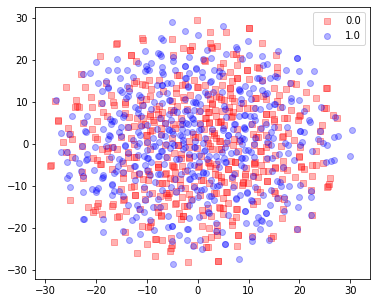

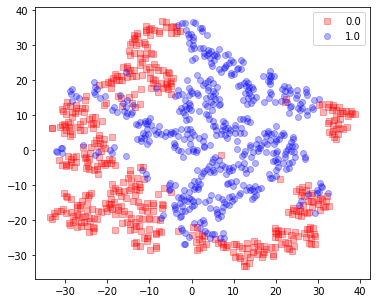

In [57]:
P_rowspace = np.eye(100)  - P
tsne(x_dev[:1000], y_dev[:1000])
x_dev_rowspace = P_rowspace.dot(x_dev.T).T
tsne(x_dev_rowspace[:1000], y_dev[:1000])

## Sanity checks

In [4]:
def do_sanity_check(P, Ws, x_train):

    assert np.allclose(P.dot(P), P)
    assert np.allclose(Ws[0].dot(P.dot(x_train[0])), 0.0)

    for w in Ws:
        for w2 in Ws:
            if w is w2: continue
            assert np.allclose(w.dot(w2.T).item(), 0.0)
            
do_sanity_check(P, Ws, x_train)

## Siamese

In [ ]:
x_train1, x_train2 = np.random.rand(1000,100) - 0.5,  np.random.rand(1000,100) - 0.5,
x_dev1, x_dev2 =  np.random.rand(1000,100) - 0.5, np.random.rand(1000,100) - 0.5

y_train = (np.sign(np.sum(x_train1, axis = 1)) ==  np.sign(np.sum(x_train2, axis = 1))).astype(int)
y_dev = (np.sign(np.sum(x_dev1, axis = 1)) ==  np.sign(np.sum(x_dev2, axis = 1))).astype(int)

inlp_dataset = inlp_dataset_handler.SiameseDatasetHandler((x_train1, x_train2), y_train, (x_dev1, x_dev2), y_dev, dropout_rate = 0, Y_train_main = None, Y_dev_main = None, by_class = False, equal_chance_for_main_task_labels = False)
params = {"num_iter": 25, "input_dim": 100, "hidden_dim": 32, "batch_size": 32, "verbose": False, "device": "cuda",
         "compare_by": "cosine", "same_weights": True}
inlp_model_handler = inlp_linear_model.SiameseLinearClassifier(model_params = params, concat_weights = True)

In [ ]:
#inlp_model_handler.train_model(inlp_dataset)
P, rowspace_projections, Ws = inlp.run_INLP(num_classifiers = 3, input_dim = 100, is_autoregressive = True, min_accuracy = 0, dataset_handler = inlp_dataset, model = inlp_model_handler)

## note that the cosine/l2 distance loss is no longer convex, so w_i.dot(w_j) != 0

In [ ]:
Ws[0].dot(Ws[1].T)

In [ ]:
print(np.linalg.norm(P.dot(P) - P))
print( np.linalg.norm( Ws[-1][:32, :].dot(P.dot(x_train1[0]))) ) # note that the norm is not exactly 0 due to pytorch floating point precision

# Metric Siamese

In [2]:
from sklearn.datasets import fetch_openml
from sklearn.utils import shuffle
import random
mnist = fetch_openml('mnist_784')

### Prepare MNIST data

In [43]:
COLOR_MNIST = True

if not COLOR_MNIST:
    X,Y = mnist.data, np.array([int(y) for y in mnist.target])
    X,Y = shuffle(X,Y)
    X_strs = np.array([""]*len(X))
else:
    
    with open("mnist.colored.dict.pickle", "rb") as f:    
        data = pickle.load(f)
    X = np.array([d["x"].reshape(-1) for d in data])
    Y = np.array([int(d["y"]) for d in data])
    X_strs = np.array([d["color"][0] for d in data])

X_mean = np.mean(X, axis = 0, keepdims = True)
X -= X_mean

data = []
label_set = range(10)
k = 2000 # num examples per digit

for y in label_set:
    
    idx = Y == y
    relevant = X[idx]
    
    x1_idx, x2_idx = np.random.choice(relevant.shape[0], k, replace=False), np.random.choice(relevant.shape[0], k, replace=False)
    x1 = relevant[x1_idx, :]
    x2 = relevant[x2_idx, :]
    
    x1_strs, x2_strs = X_strs[x1_idx], X_strs[x2_idx]
    
    tuples = list(zip(x1,x2))
    ids = [(y,y)]*k
    strs = list(zip(x1_strs, x2_strs)) #[("", "")]*k
    data.extend(list(zip(tuples, strs, ids)))

random.shuffle(data)
l = int(0.8*len(data))
train,dev = data[:l], data[l:]



x_train, sents_train, ids_train = map(list, zip(*train))
x_train1, x_train2 = map(np.array, zip(*x_train))
sents_train1, sents_train2 = map(np.array, zip(*sents_train))
ids_train1, ids_train2 = map(np.array, zip(*ids_train))

x_dev, sents_dev, ids_dev = map(list, zip(*dev))
x_dev1, x_dev2 = map(np.array, zip(*x_dev))
sents_dev1, sents_dev2 = map(np.array, zip(*sents_dev))
ids_dev1, ids_dev2 = map(np.array, zip(*ids_dev))

#x_train1, x_train2, x_dev1, x_dev2 = np.map(np.array, zip(*train, np.array(x_dev1), np.array(x_dev2)
#sents_train1, sents_train2, sents_dev1, sents_dev2 = np.array(sents_train1), np.array(sents_train2), np.array(sents_dev1), np.array(sents_dev2)
#ids_train1, ids_train2, ids_dev1, ids_dev2 = np.array(ids_train1), np.array(ids_train2), np.array(ids_dev1), np.array(ids_dev2)

In [44]:
x = x_dev1[0]
np.mean(X, axis = 0)[:10]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [45]:
del x_train
del x_dev
del train
del dev

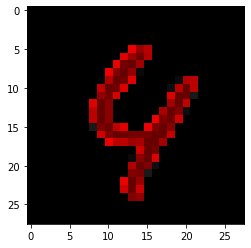

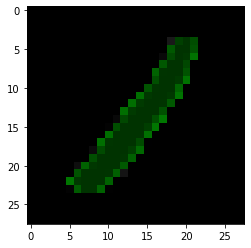

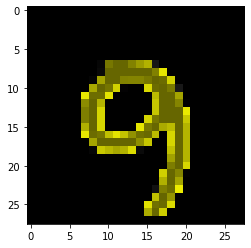

In [46]:
def show_some_images(images, n = 3, grayscale = True):
  
  for index, image in enumerate(images[:n]):
    if grayscale:
        plt.imshow(image.reshape(28,28),cmap='gray')
    else:
        plt.imshow(image.reshape(28,28,3))
    plt.show()
show_some_images(x_dev1 + X_mean, grayscale = False)

### INLP

In [47]:
siamese_dataset_handler = inlp_dataset_handler.MetricSiameseDatasetHandler((x_train1, x_train2), (x_dev1, x_dev2), (sents_train1, sents_train2), (ids_train1, ids_train2),(sents_dev1, sents_dev2), (ids_dev1, ids_dev2))

In [54]:
from siamese_model import SiameseMetric
params = {"input_dim": x_train1.shape[1], "hidden_dim": 32, "batch_size": 32, "verbose": False,
         "k": 1, "p": 2, "alpha": 0.5, "mode": "cosine", "final": "softmax", "device": "cpu", "num_iter": 5,
         "bias": False, "optimizer_type": "sgd", "l1_coeff": 0.5*1e-4}
inlp_model_handler = inlp_linear_model.SiameseMetricLearning(model_class = SiameseMetric, model_params = params)

In [55]:
P, rowspace_projections, Ws = inlp.run_INLP(num_classifiers = 2, input_dim = x_train1.shape[1], is_autoregressive = True, min_accuracy = 0, dataset_handler = siamese_dataset_handler, model = inlp_model_handler)

  0%|          | 0/2 [00:00<?, ?it/s]INFO:root:      Name                  Type Params
0        l                Linear   75 K
1  loss_fn  BatchHardTripletLoss    0  
/home/shauli/miniconda3/envs/py3/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer_io.py:210: UserWarning: Did not find hyperparameters at model.hparams. Saving checkpoint without hyperparameters
  "Did not find hyperparameters at model.hparams. Saving checkpoint without"
iteration: 0, accuracy: 0.23225000500679016:  50%|█████     | 1/2 [00:26<00:26, 26.91s/it]INFO:root:      Name                  Type Params
0        l                Linear   75 K
1  loss_fn  BatchHardTripletLoss    0  
iteration: 1, accuracy: 0.15549999475479126: 100%|██████████| 2/2 [00:56<00:00, 28.44s/it]


In [56]:
P_rowspace = np.eye(x_dev1.shape[1]) - P
w_concat = np.concatenate(Ws[:])
P_concat = inlp.get_rowspace_projection(w_concat)
assert np.allclose(P_rowspace, P_concat)

### Tsne

In [29]:
def tsne(vecs, labels, title="", words = None, metric = "l2", color_gradient = False):

  tsne = TSNE(n_components=2, random_state=0, metric = metric)
  vecs_2d = tsne.fit_transform(vecs)
  num_labels = len(set(labels.tolist()))

  #names = ["digit={}".format(int(i)) for i in labels.tolist()]
  #names = ["class {}".format(i) for i in range(num_labels)]
  names = sorted(set(labels.tolist()))
  

  if not color_gradient:
      plt.figure(figsize=(6, 5))
      colors = "red", "green", "blue", "cyan", "yellow", "orange", "brown", "black", "purple", "pink"
      #colors = [(255,13,12) for n in names]
    
      for i, c, label in zip(sorted(set(labels.tolist())), colors, names):
        #print(len(vecs_2d[labels == i, 0]))
        plt.scatter(vecs_2d[labels == i, 0], vecs_2d[labels == i, 1], c=c,
                    label=label, alpha = 0.3)
      plt.legend()
  
  else:
        fig, ax = plt.subplots()
        N = num_labels
        # define the colormap
        cmap = plt.cm.jet
        # extract all colors from the .jet map
        cmaplist = [cmap(i) for i in range(cmap.N)]
        # create the new map
        cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)
        # define the bins and normalize
        bounds = np.linspace(0, N, N + 1)
        norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

        scat = ax.scatter(vecs_2d[:, 0], vecs_2d[:, 1], c = labels, cmap=cmap, norm=norm, alpha=1)
        cb = plt.colorbar(scat, spacing='proportional', ticks=bounds)
        cb.set_label("label")

  plt.title(title)

### Tsne by mnist digit indentity, before

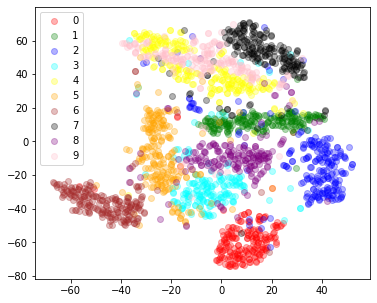

In [14]:
tsne(x_dev1[:1200], ids_dev1[:1200])

### Tsne by mnist digit indentity, rowspace

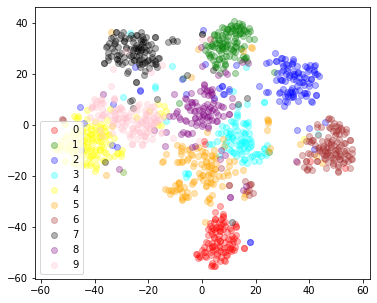

In [24]:
tsne(P_concat.dot(x_dev1.T).T[:1200], ids_dev1[:1200])

### Tsne by mnist digit identity, concat-rowspace

In [25]:
#tsne(P_concat.dot(x_dev1.T).T[:2000], ids_dev1[:2000])

### Tsne by mnist digit indentity, nullspace

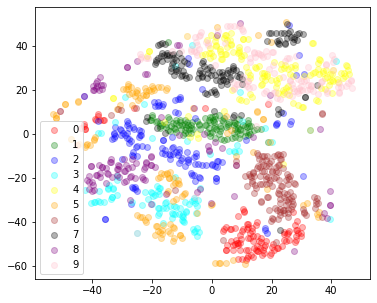

In [16]:
tsne(P.dot(x_dev1.T).T[:1200], ids_dev1[:1200])

### V measure

In [57]:
def compute_v_measure(vecs, labels_true, k=10):
        np.random.seed(0)
        clustering = sklearn.cluster.KMeans(n_clusters = k, random_state = 0)
        clustering.fit(vecs)
        labels_pred = clustering.labels_
        return sklearn.metrics.v_measure_score(labels_true, labels_pred)

k = 10 #len(set(data_for_tsen_deps.tolist()))
v_before = compute_v_measure(x_dev1[:5000], ids_dev1[:5000], k = k)
v_rowspace = compute_v_measure(P_rowspace.dot(x_dev1.T).T[:5000], ids_dev1[:5000], k = k)
v_nullspace = compute_v_measure(P.dot(x_dev1.T).T[:5000], ids_dev1[:5000], k = k)
print("V measure, original: {}\n V-measure, INLP-rowspace: {}\n V-measure, INLP-nullspace: {}".format(v_before, v_rowspace, v_nullspace))

V measure, original: 0.06409447467628236
 V-measure, INLP-rowspace: 0.520440059169813
 V-measure, INLP-nullspace: 0.04934673134201982


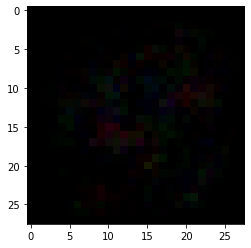

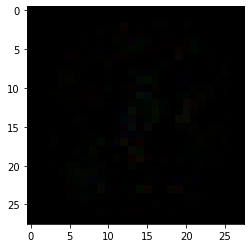

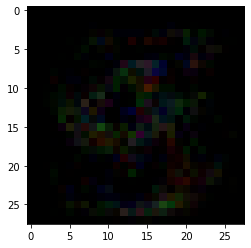

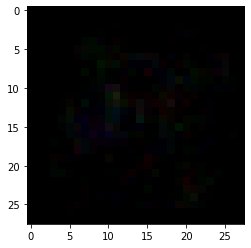

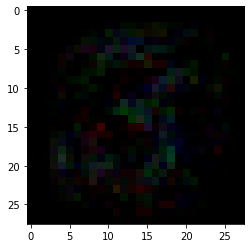

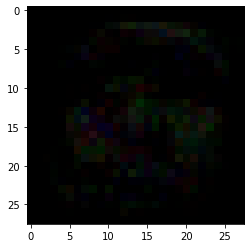

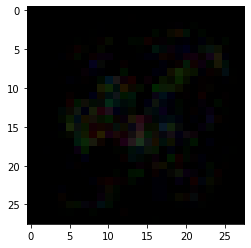

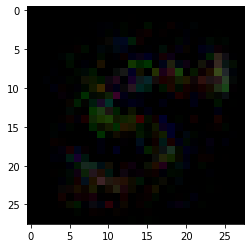

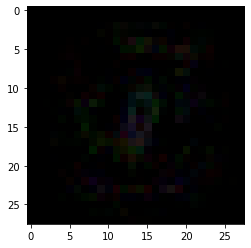

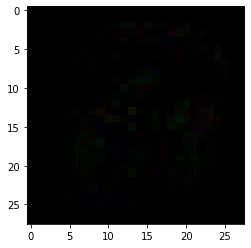

In [53]:
show_some_images(P_rowspace.dot(x_dev1.T).T, n = 10, grayscale=False)